In [12]:
# import the necessary packages
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import argparse
import utils
import cv2
import numpy as np
import colorsys
from PIL import Image

In [13]:
# hist = histogram, centroids = cluster centers
# returns list of primary colors sorted by number of clusters each color has
def rank_colors(hist, centroids):
    '''
    white = [255,255,255]
    yellow = [255,255,0]
    orange = [255,165,0]
    red = [255,0,0]
    brown = [165,42,42]
    gray = [128,128,128]
    purple = [128,0,128]
    green = [0,255,0]
    blue = [0,0,255]
    black = [0,0,0]
    '''
    
    colors_count = {}
    
    for (percent, color) in zip(hist, centroids):
        print(color)
        r,g,b = color
        # fill colors_count -> get the number of clusters for each color
        if (r<=192):
            if(r<=64 and g<=128 and b<=128):
                key = 'black'
            if(r<=64 and g<=128 and b>128):
                key = 'blue'
            if(r<=64 and g>128):
                key = 'green'
            if(r>64 and g<=85 and b<=85):
                key = 'brown'
            if(r>64 and g<=85 and b>85):
                key = 'purple'
            if(r>64 and g>85):
                key = 'gray'
        else:
            if(g<=82):
                key = 'red'
            else:
                if(b>128):
                    key = 'white'
                else:
                    if(g<=210):
                        key = 'orange'
                    else:
                        key = 'yellow'
        colors_count.setdefault(key, 0)
        colors_count[key]+=1
                            
    # sort colors_count by value
    ranks = sorted(colors_count.items(), key=lambda x: x[1])
    return ranks[::-1]

In [14]:
#made with help from https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image
# replaces background with given color in bgr and saves to new path
    # default color = yellow bc yellow is not used as a shoe color
    #img_path = src, new_img_path = dest
def replace_background(img_path, new_img_path, color=(0.0,1.0,1.0)):
    #== Parameters =======================================================================
    BLUR = 21
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 200
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = color # yellow In BGR format
    #== Processing =======================================================================

    #-- Read image -----------------------------------------------------------------------
    img = cv2.imread(str(img_path))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    #  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

    #cv2.imshow('img', masked)                                   # Display
    #cv2.waitKey(5)
    cv2.imwrite(new_img_path, masked)

In [15]:
# formal will only allow colors black, light brown, dark brown

def rank_colors_pixels_HSV2_formal(image):
    '''
    white = [255,255,255]
    yellow = [255,255,0]
    orange = [255,165,0]
    red = [255,0,0]
    brown = [165,42,42]
    gray = [128,128,128]
    purple = [128,0,128]
    green = [0,255,0]
    blue = [0,0,255]
    black = [0,0,0]
    '''
    
    colors_count = {}
    
    for r,g,b in image:
        key = ''
        hue,saturation,brightness = colorsys.rgb_to_hsv(r,g,b)
        brightness = brightness/255
        hue = hue*360
        #print(hue,saturation,brightness)
        
        if (brightness>0 and brightness<=0.2):
            key='black'
        #elif (saturation > 0 and saturation<=0.5) and (brightness>0.8 and brightness<=1.0):
        #    key='white'
        elif (hue>15 and hue<=45) and (saturation > 0.2 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>30 and hue<=45) and (saturation > 0.3 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>330 and hue<=360) and (saturation > 0.3 and saturation<=1.0) and (brightness>0.3 and brightness<=0.4):
            key='dbrown'
        elif (hue>=0 and hue<=15) or (hue>345 and hue<=360):
            key='red'
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            elif (brightness>0.5 and brightness <= 1.0):
                key='lbrown'
            #elif (brightness>0.8):
            #    key='white'
            elif (brightness<0.3):
                key='black'
        
        '''
        if (saturation > 0.075 and saturation<=0.1) and (brightness>0.3 and brightness<=0.6):
            key='gray'
        elif (saturation > 0.05 and saturation<=0.075) and (brightness>0.3 and brightness<=0.75):
            key='gray'
        elif (saturation > 0 and saturation<=0.05) and (brightness>0.3 and brightness<=0.8):
            key='gray'
        
        elif (hue>295 and hue<=345):
            key='pink'
        elif (hue>265 and hue<=295):
            key='purple'
        elif (hue>165 and hue<=265):
            key='blue'
        elif (hue>65 and hue<=165):
            key='green'
        
        elif (hue>45 and hue<=65):
            key='yellow'
        
        elif (hue>15 and hue<=45):
            key='orange'
        '''
    
    
        colors_count.setdefault(key, 0)
        colors_count[key]+=1
    
                            
    # sort colors_count by value
    ranks = sorted(colors_count.items(), key=lambda x: x[1])
    return ranks[::-1]

In [16]:
def rank_colors_pixels_HSV2_sport(image):
    colors_count = {}
    
    for r,g,b in image:
        key = ''
        hue,saturation,brightness = colorsys.rgb_to_hsv(r,g,b)
        brightness = brightness/255
        hue = hue*360
        #print(hue,saturation,brightness)
        
        if (saturation > 0.075 and saturation<=0.1) and (brightness>0.3 and brightness<=0.6):
            key='gray'
        elif (saturation > 0.05 and saturation<=0.075) and (brightness>0.3 and brightness<=0.75):
            key='gray'
        elif (saturation >= 0 and saturation<=0.05) and (brightness>0.3 and brightness<=0.8):
            key='gray'
        elif (brightness>=0 and brightness<=0.2):
            key='black'
        elif (saturation >= 0 and saturation<=0.25) and (brightness>0.8 and brightness<=1.0):
            key='white'
        elif (hue>15 and hue<=45) and (saturation > 0.2 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>30 and hue<=45) and (saturation > 0.3 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>330 and hue<=360) and (saturation > 0.3 and saturation<=1.0) and (brightness>0.3 and brightness<=0.4):
            key='dbrown'

        elif (hue>=0 and hue<=15) or (hue>345 and hue<=360):
            key='red'
        elif (hue>295 and hue<=345):
            key='pink'
        elif (hue>265 and hue<=295):
            key='purple'
        elif (hue>165 and hue<=265):
            key='blue'
        elif (hue>65 and hue<=165):
            key='green'
        
        elif (hue>45 and hue<=65):
            key='yellow'
        '''
        elif (hue>15 and hue<=45):
            key='orange'
        '''
    
    
        colors_count.setdefault(key, 0)
        colors_count[key]+=1
    
                            
    # sort colors_count by value
    ranks = sorted(colors_count.items(), key=lambda x: x[1])
    return ranks[::-1]

In [17]:
# returns list of primary colors sorted by number of pixels each color has
def rank_colors_pixels_HSV2(image, shoe_type='formal'):
    '''
    white = [255,255,255]
    yellow = [255,255,0]
    orange = [255,165,0]
    red = [255,0,0]
    brown = [165,42,42]
    gray = [128,128,128]
    purple = [128,0,128]
    green = [0,255,0]
    blue = [0,0,255]
    black = [0,0,0]
    '''
    
    if (shoe_type == 'formal'):
        return rank_colors_pixels_HSV2_formal(image)
    if (shoe_type == 'sport'):
        return rank_colors_pixels_HSV2_sport(image)

In [18]:
#takes sorted list of colors, returns most prominent that is not yellow or invalid
def get_best(ranks):
    index = 0
    while (ranks[index][0]=='yellow' or ranks[index][0]==''): # color key at that index
        index+=1
    return ranks[index]

In [19]:
def color_recognition(img_path, new_img_path, shoe_type='formal'):
    '''
    # construct the argument parser and parse the arguments
    ap = argparse.ArgumentParser()
    ap.add_argument("-i", "--image", required = True, help = "Path to the image")
    ap.add_argument("-c", "--clusters", required = True, type = int,
        help = "# of clusters")
    #args = vars(ap.parse_args())
    '''
    
    # load the image and convert it from BGR to RGB so that
    # we can dispaly it with matplotlib
    #image = cv2.imread(args["image"])
    replace_background(img_path, new_img_path)
    #image = cv2.imread(str(img_path))
    image = cv2.imread(str(new_img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # show our image
    plt.figure()
    plt.axis("off")
    plt.imshow(image)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    '''
    # cluster the pixel intensities

    #clt = KMeans(n_clusters = args["clusters"])
    clt = KMeans(n_clusters=10)
    clt.fit(image)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = utils.centroid_histogram(clt)
    bar = utils.plot_colors(hist, clt.cluster_centers_)
    '''
    
    #ranks = rank_colors(hist, clt.cluster_centers_)
    ranks = rank_colors_pixels_HSV2(image, shoe_type)
    best = get_best(ranks)
    return best
    '''
    # show our color bart
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    '''

('black', 5042)

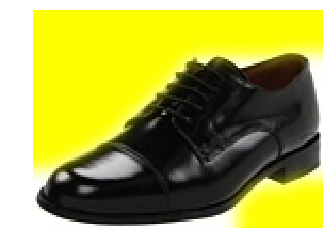

In [22]:
img_path = "C:\\Users\jason\\UT\Junior_1st_Semester\EE_460J\\finalProject\DataScienceFinalProject\Formals\\100627.72.jpg"
new_img_path = "C:\\Users\jason\\UT\Junior_1st_Semester\EE_460J\\finalProject\DataScienceFinalProject\Formals\\100627.72_new.jpg"
color_recognition(img_path, new_img_path,'formal')   